## mevpy package: tests and examples

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.append('../src')
import mevpy as mev

matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.style.use('seaborn-v0_8')

Test functions for fitting - plotting the Weibull distribution

sample =  13.86980774052919 279.75010130000834
theo = 8.860764542400984 167.91494212900452


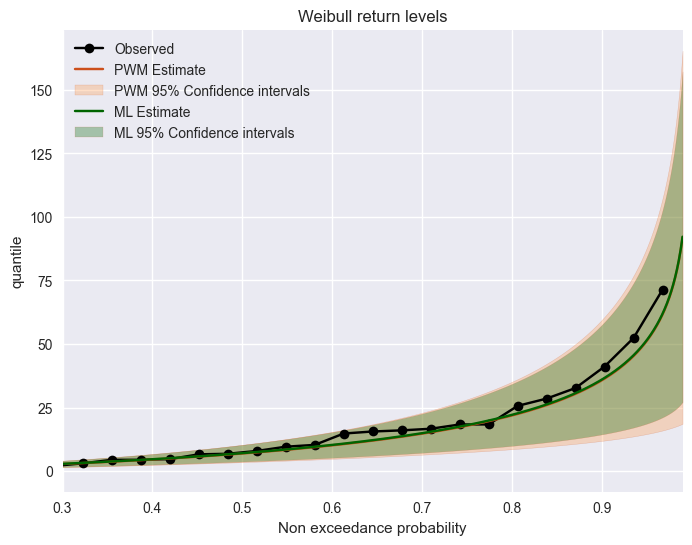

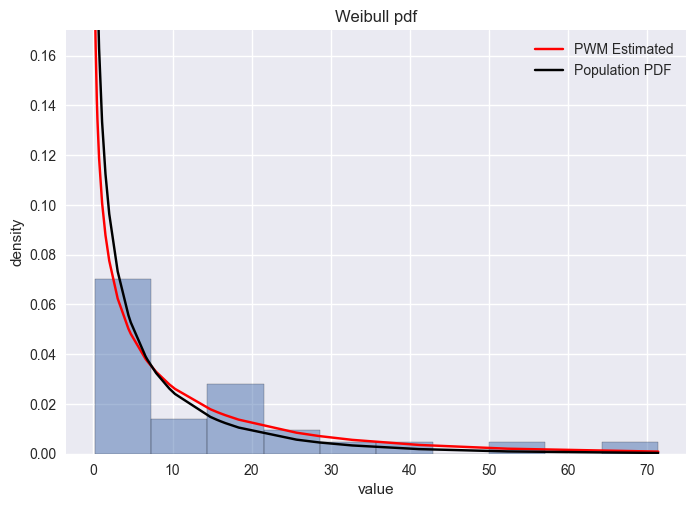

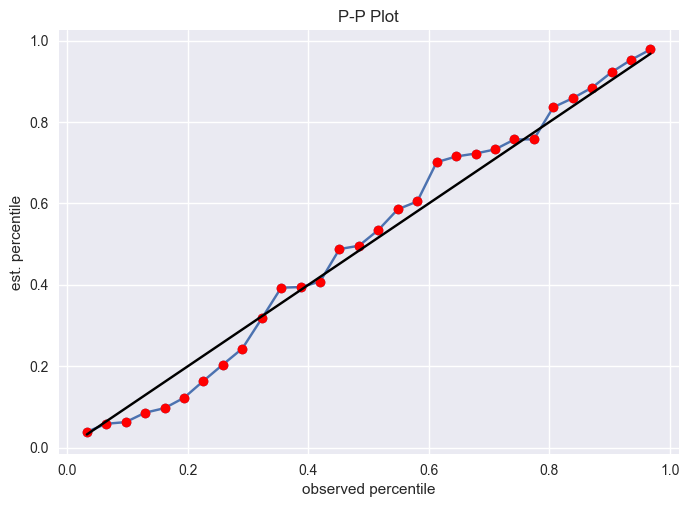

In [2]:
# Generate Weibull random variates
length = 30
C = 7
w = 0.7
sample = mev.wei_random_quant(length,C,w)
xi = np.sort(sample)
fi = np.arange(1,length + 1)/(length + 1)

# check mean and variance
musam  = np.mean(sample)
varsam = np.var(sample)
muteo, varteo = mev.wei_mean_variance(C,w)
print('sample = ', musam, varsam) # Sample statistics
print('theo =', muteo, varteo) # Population Parameters

# fit Weibull with various methods and produce bootstrap confidence Intervals
''' 
wei_fit() returns (parhat= (n, c, w), parstd, varcov) where
   n = Sample size
   c = Scale parameter
   w = Shape parameter
'''
res_pwm = mev.wei_fit(sample, how = 'pwm', threshold = 0, std = True, std_how = 'boot', std_num = 1000)
res_ml = mev.wei_fit(sample, how = 'ml', threshold = 0, std = True, std_how = 'boot', std_num = 1000)
res_ls = mev.wei_fit(sample, how = 'ls', threshold = 0, std = True, std_how = 'boot', std_num = 1000)

# Fi = np.linspace(0.001,0.999,1000)
Fi = np.linspace(0.3,0.99,1000)
pq,pqu,pql = mev.wei_quant(Fi, res_pwm[0][1], res_pwm[0][2], ci = True, varcov = res_pwm[2])
mq,mqu,mql = mev.wei_quant(Fi, res_ml[0][1], res_ml[0][2], ci = True, varcov = res_ml[2])
lq,lqu,lql = mev.wei_quant(Fi, res_ls[0][1], res_ls[0][2], ci = True, varcov = res_ls[2])

# Plotting the inverse CDF = Quantile Function = Return Level

fig, ax = plt.subplots(figsize=(8, 6))
ax.set(title='Weibull return levels',
      ylabel='quantile', xlabel='Non exceedance probability')

ax.set_xlim([ np.min(Fi), np.max(Fi)])
# ax.set_ylim([-2, 8])
ax.plot(fi,xi, color='black', marker = 'o', label = 'Observed')
ax.plot(Fi,pq, color='#CC4F1B', label = 'PWM Estimate')
ax.fill_between(Fi, pql, pqu,
   alpha=0.3, edgecolor='#CC4F1B', facecolor='#FF9848', label = 'PWM 95% Confidence intervals')

ax.plot(Fi,mq, color='darkgreen', label = 'ML Estimate')
ax.fill_between(Fi, mql, mqu,
   alpha=0.3, edgecolor='#CC4F1B', facecolor='darkgreen', label = 'ML 95% Confidence intervals')
ax.legend(loc='upper left')
   
#ax.plot(Fi,lq, color='yellow', label = 'LS Estimate')
#ax.fill_between(Fi, lql, lqu,
#    alpha=0.5, edgecolor='yellow', facecolor='yellow', label = 'LS 95% Confidence intervals')
#ax.legend(loc='upper left')
   
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend(loc='upper left')
plt.show()

# PWM estimates
Chat = res_pwm[0][1]
what = res_pwm[0][2]

centers, emppdf = mev.emp_pdf(sample, nbins = 10)
weipdf = mev.wei_pdf(xi, Chat, what)

# Plotting PDF

fig, ax = plt.subplots()
ax.set(title='Weibull pdf',
      ylabel='density', xlabel='value')
ax.set_ylim([ 0, np.max(emppdf)+0.1])
ax.bar(centers, emppdf, width=centers[1]-centers[0], alpha=0.5, align='center', ec='k')
#ax.plot(centers,emppdf, color='black', marker = 'o', label = 'Observed')
ax.plot(xi,weipdf, color='red', label = 'PWM Estimated')
ax.plot(xi,mev.wei_pdf(xi, C, w), color='black', label = 'Population PDF')
ax.legend(loc='upper right')
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

# Weibull CDF and survival function
fhi = mev.wei_cdf(xi, Chat, what)
shi = mev.wei_surv(xi, Chat, what)
fig = plt.figure()
plt.plot(fi, fhi,'-o')
plt.plot(fi, 1-shi,'or')
plt.plot(fi,fi,'k')
plt.xlabel('observed percentile')
plt.ylabel('est. percentile')
plt.title('P-P Plot')
plt.show()

2) TEST MEV FUNCTIONS 

In [3]:
# PRCP in [mm]

df = pd.read_csv('../data/padova/PADOVA_1725_2022_PRCPdaily_reorganize.csv')
#df['DATE'] = pd.to_datetime((df.YY*10000+df.MM*100+df.DD).apply(str),format='%Y%m%d')
df['DATE'] = (df.YY*10000+df.MM*100+df.DD).apply(str)
df = df.drop(['DD', 'MM'], axis=1)[['DATE', 'YY', 'PRCP']].rename(columns={'YY':'YEAR'})
df.head()

,DATE,YEAR,PRCP
0,17250101,1725,0.0
1,17250102,1725,0.0
2,17250103,1725,0.0
3,17250104,1725,0.0
4,17250105,1725,0.0


In [4]:
# remove years with more than 10% of missing data
nmin = 36
df, ny, ny_old  = mev.remove_missing_years(df, nmin)
print(ny, ny_old)

284 284


In [6]:
# compute annual maxima and their frequency
Xi_, Fi_, TR_ = mev.tab_rain_max(df)


# annual maxima and yearly Weibull parameters
# TODO: Select non-zero rainfall
Xi, Fi, TR, NCW = mev.table_rainfall_maxima(df, how = 'pwm', thresh= 0, declu=False)
#print(Xi_ - Xi)

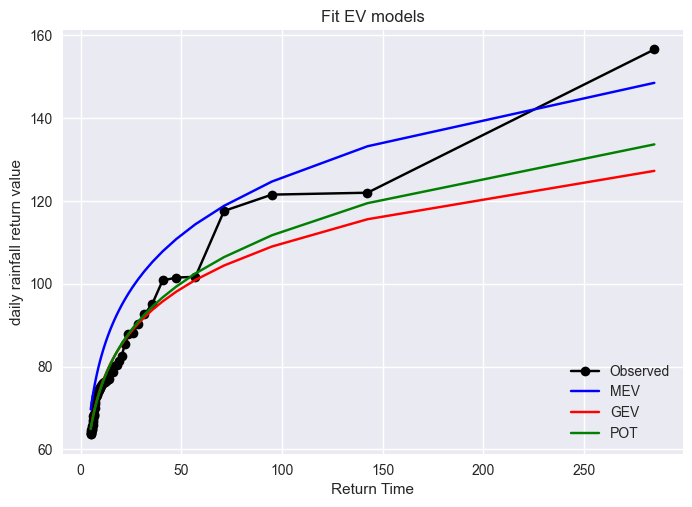

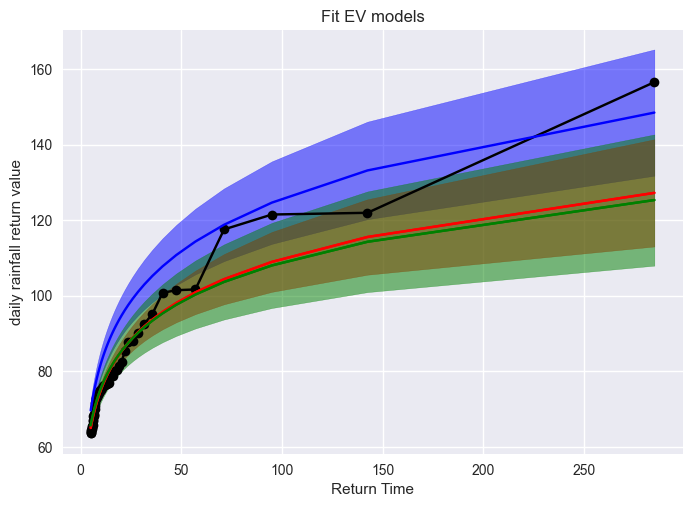

In [10]:
# fit Extreme Value Models
TR_val, XI_val, Fi_val, QM, QG, QP, FhM, FhG, FhP, flags = mev.fit_EV_models(
                  df, tr_min = 5, ws = 1, GEV_how = 'lmom', MEV_how = 'pwm', 
                MEV_thresh = 1, POT_way = 'ea', POT_val = 1, POT_how = 'ml', declu=True)

# plot quantiles
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title='Fit EV models',
      ylabel='daily rainfall return value', xlabel='Return Time')
ax.plot(TR_val, XI_val, color='black', marker = 'o', label = 'Observed')
ax.plot(TR_val, QM, color='blue', label = 'MEV')
ax.plot(TR_val, QG, color='red', label = 'GEV')
ax.plot(TR_val, QP, color='green', label = 'POT')
ax.legend(loc='lower right')
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

# with confidence intervals
TR_val, XI_val, Fi_val, QM, QG, QP, \
    QuM, QuG, QuP, QlM, QlG, QlP, FhM, FhG, FhP, flags  =  \
   mev.fit_EV_models(df, tr_min = 5, ws = 1, GEV_how = 'lmom', MEV_how = 'pwm', \
    MEV_thresh = 1, POT_way = 'ea', POT_val = 3, POT_how = 'ml', \
       ci = True, ntimes = 10, std_how_MEV= 'boot', std_how_GEV = 'hess', std_how_POT = 'hess', declu=True)

# plot results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title='Fit EV models',
      ylabel='daily rainfall return value', xlabel='Return Time')
ax.plot(TR_val, XI_val, color='black', marker = 'o', label = 'Observed')
ax.plot(TR_val, QM, color='blue', label = 'MEV')
ax.plot(TR_val, QG, color='red', label = 'GEV')
ax.plot(TR_val, QP, color='green', label = 'POT')

ax.fill_between(TR_val, QlM, QuM,
   alpha = 0.5, edgecolor='blue', facecolor='blue', label = 'MEV 95% Confidence intervals')


ax.fill_between(TR_val, QlG, QuG,
   alpha = 0.5, edgecolor='red', facecolor='red', label = 'GEV 95% Confidence intervals')


ax.fill_between(TR_val, QlP, QuP,
   alpha = 0.5, edgecolor='green', facecolor='green', label = 'POT 95% Confidence intervals')

ax.plot(TR_val, QG, color='red', label = 'GEV')
ax.plot(TR_val, QP, color='green', label = 'POT')
# ax.legend(loc='lower right')
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

TEST CROSS VALIDATION

Sliding window analysis

slideover _ window =  0 of 255
slideover _ window =  1 of 255
slideover _ window =  2 of 255
slideover _ window =  3 of 255
slideover _ window =  4 of 255
slideover _ window =  5 of 255
slideover _ window =  6 of 255
slideover _ window =  7 of 255
slideover _ window =  8 of 255
slideover _ window =  9 of 255
slideover _ window =  10 of 255
slideover _ window =  11 of 255
slideover _ window =  12 of 255
slideover _ window =  13 of 255
slideover _ window =  14 of 255
slideover _ window =  15 of 255
slideover _ window =  16 of 255
slideover _ window =  17 of 255
slideover _ window =  18 of 255
slideover _ window =  19 of 255
slideover _ window =  20 of 255
slideover _ window =  21 of 255
slideover _ window =  22 of 255
slideover _ window =  23 of 255
slideover _ window =  24 of 255
slideover _ window =  25 of 255
slideover _ window =  26 of 255
slideover _ window =  27 of 255
slideover _ window =  28 of 255
slideover _ window =  29 of 255
slideover _ window =  30 of 255
slideover _ window

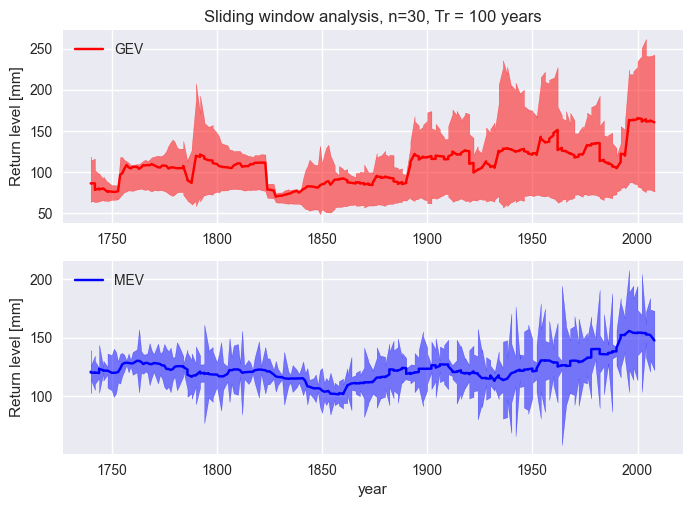

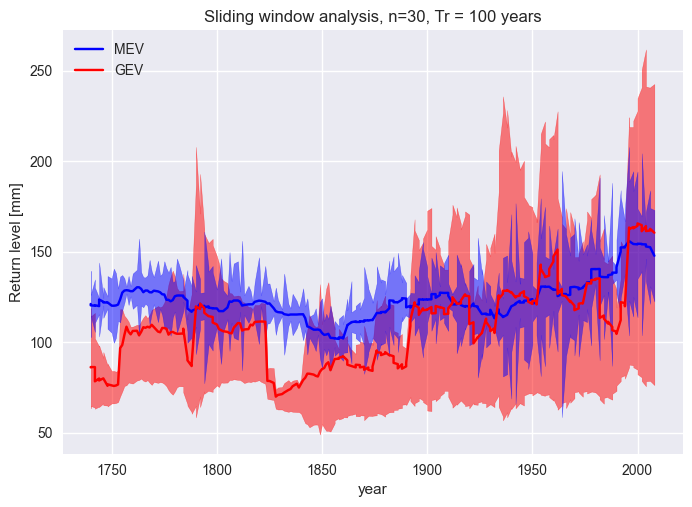

In [11]:
central_year, mq, mqu, mql, gq, gqu, gql, pq, pqu, pql, fig1, fig2 = mev.slideover(
                   df, winsize = 30, Tr = 100, ci = True, display = True, ntimes = 3, MEV_thresh=1, declu=False)
# fig1.savefig('output_GRL/slideover/slideover_1.jpg', format='jpg', dpi = 300)
# fig2.savefig('output_GRL/slideover/slideover_2.jpg', format='jpg', dpi = 300)

slideover _ window =  0 of 255
slideover _ window =  1 of 255
slideover _ window =  2 of 255
slideover _ window =  3 of 255
slideover _ window =  4 of 255
slideover _ window =  5 of 255
slideover _ window =  6 of 255
slideover _ window =  7 of 255
slideover _ window =  8 of 255
slideover _ window =  9 of 255
slideover _ window =  10 of 255
slideover _ window =  11 of 255
slideover _ window =  12 of 255
slideover _ window =  13 of 255
slideover _ window =  14 of 255
slideover _ window =  15 of 255
slideover _ window =  16 of 255
slideover _ window =  17 of 255
slideover _ window =  18 of 255
slideover _ window =  19 of 255
slideover _ window =  20 of 255
slideover _ window =  21 of 255
slideover _ window =  22 of 255
slideover _ window =  23 of 255
slideover _ window =  24 of 255
slideover _ window =  25 of 255
slideover _ window =  26 of 255
slideover _ window =  27 of 255
slideover _ window =  28 of 255
slideover _ window =  29 of 255
slideover _ window =  30 of 255
slideover _ window

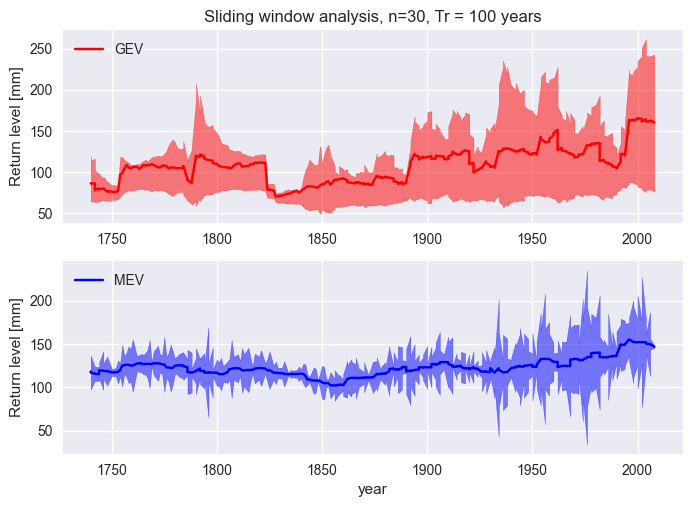

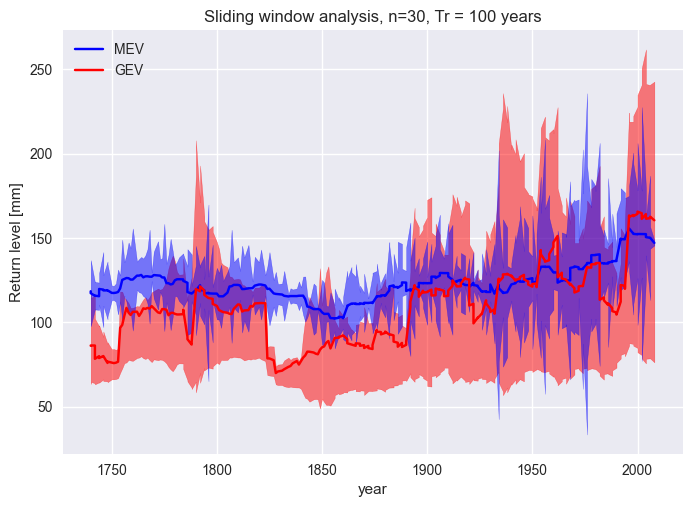

In [12]:
central_year, mq, mqu, mql, gq, gqu, gql, pq, pqu, pql, fig1, fig2 = mev.slideover(
                   df, winsize = 30, Tr = 100, ci = True, display = True, ntimes = 3, MEV_thresh=1, declu=True)